In [2]:
%cd /content
! rm -rf gan-tools2
!git clone --single-branch --depth=1 --branch main https://github.com/hannesdm/gan-tools2.git
%cd /content/gan-tools2

from keras.datasets import mnist
from keras import initializers
from keras import Sequential
from keras.layers import  Dense
from core.gan import GAN, WGAN, WGAN_GP
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.grid'] = False
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


/content
Cloning into 'gan-tools2'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (16/16), 7.11 KiB | 364.00 KiB/s, done.
/content/gan-tools2


## Wasserstein GAN
We will train a standard GAN and a Wasserstein GAN on the mnist data. <br/>
Both variants have a relatively simple fully connected architecture to allow for fast training. This will inevitable produce worse results than larger or specialized models (cfr. DCGAN). <br/>
The Wasserstein GAN implementation follows the paper of Arjovsky et al. <br/>
You are encouraged to change the parameters and architecture of the model. If you do, do **not** change the **input_dim** and **final layer**. <br/>
**Exercise** Compare the performance of the different GAN formulations over
the different iterations, do you see an improvement in stability and quality of the generated samples? <br/>Elaborate based on
the knowledge you have gained about optimal transport and the Wasserstein distance.

In [3]:
(X_train_mnist, Y_train_mnist), (_, _) = mnist.load_data()
X_train_mnist = X_train_mnist.reshape((-1, 28*28))
X_train_mnist = X_train_mnist.astype('float32') / 127.5 - 1

11490434/11490434 [==============================] - 1s 0us/step


In [4]:

def mnist_generator_model():
  generator = Sequential()
  generator.add(Dense(256, input_dim=100, activation='relu'))
  generator.add(Dense(256, activation='relu'))
  generator.add(Dense(784, activation='tanh'))
  return generator

def mnist_discriminator_model():
  discriminator = Sequential()
  discriminator.add(Dense(256, input_dim=784, activation='relu'))
  discriminator.add(Dense(256, activation='relu'))
  discriminator.add(Dense(1, activation='linear'))
  return discriminator

def mnist_wgan_discriminator_model():
  discriminator = Sequential()
  discriminator.add(Dense(256, input_dim=784, activation='relu'))
  discriminator.add(Dense(256, activation='relu'))
  discriminator.add(Dense(1, activation='linear'))
  return discriminator

def mnist_weight_clipping_discriminator_model():
  discriminator = Sequential()
  discriminator.add(Dense(256, input_dim=784, activation='relu'))
  discriminator.add(Dense(256, activation='relu'))
  discriminator.add(Dense(1, activation='linear'))
  return discriminator

## Train the standard GAN
The parameters **batches**, **batch_size** and **plot_interval** may be changed if wanted. <br/>
Remember that the execution may be interrupted at any time by clicking the stop button or by selecting the 'interrupt execution' option in the runtime menu.

In [6]:
mnist_gan = GAN(discriminator=mnist_discriminator_model(), generator=mnist_generator_model())

In [8]:
mnist_gan.train(X_train_mnist, steps = 20000, batch_size=64, plot_interval = 200, image_shape=(28,28))

Output hidden; open in https://colab.research.google.com to view.

## Train the Wasserstein GAN with Weight Clipping
The Discriminator in the GAN framework now performs the role of a critic, instead of a classifier.
The original way to enforce the Lipschitz constraint on the critic is by making sure the weights lie in a compact space. This can be done by clipping the weights after each gradient update. This implementation follows the work by Arjovsky et al. See https://arxiv.org/pdf/1701.07875.pdf  <br/>

The parameters **batches**, **batch_size** and **plot_interval** may be changed if wanted. <br/>
Remember that the execution may be interrupted at any time by clicking the stop button or by selecting the 'interrupt execution' option in the runtime menu.

In [ ]:
# mnist_wgan = WGAN(discriminator=mnist_weight_clipping_discriminator_model(), generator=mnist_generator_model(), n_critic=5)
# mnist_wgan.train(X_train_mnist, steps=20000, batch_size=64,
#                                 plot_interval = 500, image_shape=(28,28))

## Wasserstein GAN with Gradient Penalty
A more natural way of enforcing the Lipschitz constraint in the Wasserstein GAN formulation is by penalizing the norm of the gradient of the critic. This implementation follows the work of Gulrajani et al. See https://arxiv.org/pdf/1704.00028.pdf <br/>
The parameters **batches**, **batch_size** and **plot_interval** may be changed if wanted. <br/>
Remember that the execution may be interrupted at any time by clicking the stop button or by selecting the 'interrupt execution' option in the runtime menu.

In [8]:
mnist_wgan_gp = WGAN_GP(discriminator=mnist_wgan_discriminator_model(), generator=mnist_generator_model(),n_critic=5)
mnist_wgan_gp.train(X_train_mnist, steps=20000, batch_size=64,
                                plot_interval = 200, image_shape=(28,28))

Output hidden; open in https://colab.research.google.com to view.

In [9]:
import vis
import matplotlib.pyplot as plt
import numpy as np
# Plot the final loss curves
def moving_average(a, n=10) :
    s = np.cumsum(a, dtype=float)
    s[n:] = s[n:] - s[:-n]
    return s[n - 1:] / n

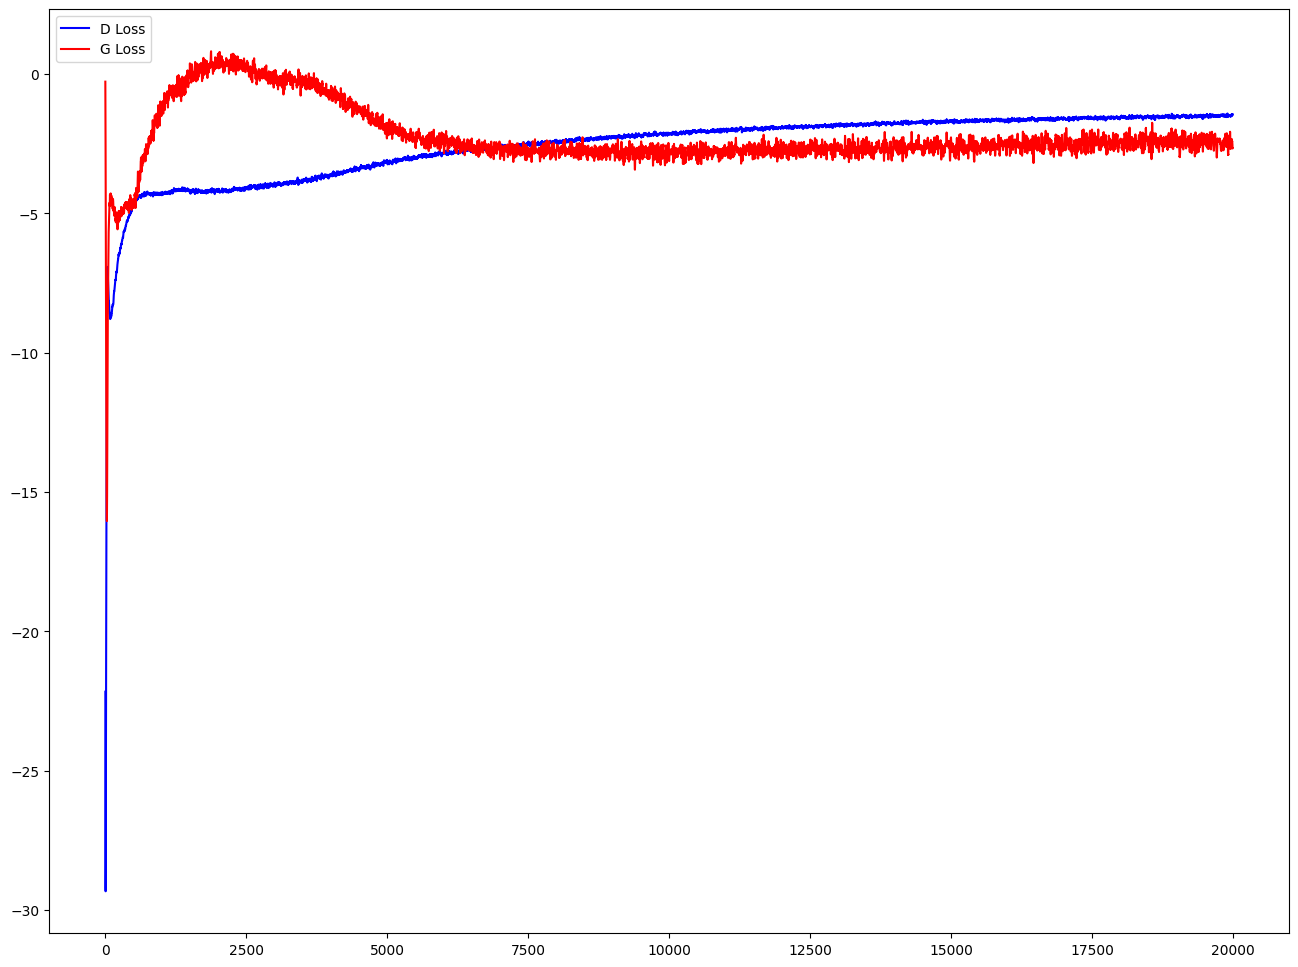

In [11]:
plt.figure(figsize=(16, 12))
plt.plot(moving_average(mnist_wgan_gp.d_losses), c="blue", label="D Loss")
plt.plot(moving_average(mnist_wgan_gp.g_losses), c="red", label="G Loss")
plt.legend(loc="upper left")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

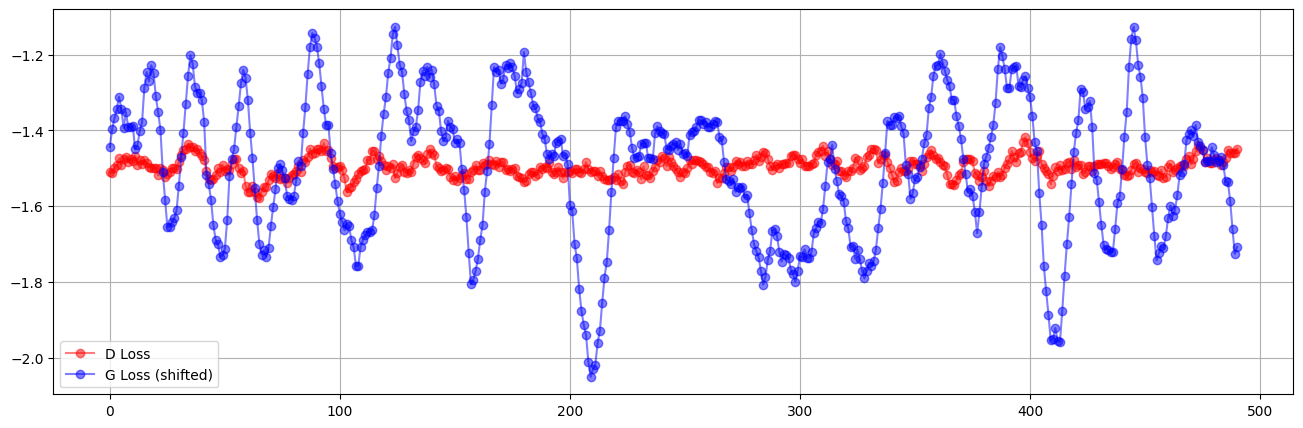

In [19]:
plt.figure(figsize=(16, 5))
cutoff = 0.975
n = 10
alpha = 0.5
d_vals = moving_average(mnist_wgan_gp.d_losses[int(cutoff*len(mnist_wgan_gp.d_losses)):], n=n) 
d_mean = np.mean(d_vals)
# plt.axhline(d_mean, ls="--", color="red",alpha=alpha)
g_vals = moving_average(mnist_wgan_gp.g_losses[int(cutoff*len(mnist_wgan_gp.g_losses)):], n=n) 
g_mean = np.mean(g_vals)
shifted_g_vals = g_vals + (d_mean - g_mean)
# plt.axhline(g_mean, ls="--", color="blue",alpha=alpha)
plt.plot(d_vals, '-o', c="red", label="D Loss", alpha = alpha)
plt.plot(shifted_g_vals, '-o', c="blue", label="G Loss (shifted)", alpha = alpha)
plt.legend(loc="lower left")
plt.grid()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Assignment 4/Plots/WGAN_losses.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# import vis
# import matplotlib.pyplot as plt
# import numpy as np
# # Plot the final loss curves
# def moving_average(a, n=10) :
#     s = np.cumsum(a, dtype=float)
#     s[n:] = s[n:] - s[:-n]
#     return s[n - 1:] / n


# plt.figure(figsize=(16, 12))
# plt.plot(moving_average(mnist_wgan.d_losses), c="blue", label="D Loss")
# plt.plot(moving_average(mnist_wgan.g_losses), c="red", label="G Loss")
# plt.legend(loc="upper left")
# plt.show()


In [ ]:
# import vis
# import matplotlib.pyplot as plt
# import numpy as np
# # Plot the final loss curves
# def moving_average(a, n=10) :
#     s = np.cumsum(a, dtype=float)
#     s[n:] = s[n:] - s[:-n]
#     return s[n - 1:] / n


# plt.figure(figsize=(16, 12))
# plt.plot(moving_average(mnist_wgan_gp.d_losses), c="blue", label="D Loss")
# plt.plot(moving_average(mnist_wgan_gp.g_losses), c="red", label="G Loss")
# plt.legend(loc="upper left")
# plt.show()
